In [36]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from Helpers.Grae import get_GRAE_networks, BaseDataset


In [37]:

"""
This script pulls in one of Marshall's embeddings to validate how well it predicts the test points embedded by GRAE
"""

import sys
sys.path.append('/yunity/msn39/ADNI-Modeling-Dashboard')  # So we can get to the ADNI Dataset class
import ADNI_Dataset_Class


# Define the path to the pickle file
file_path = os.path.join('Datasets', 'Embeddings', 'your_pickle_file.pkl')

# Load the pickle files for a profile/tau set
# folder = "/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/MASH_Profile Variables 2025-01-03-06-35_LAST_DX_DX_bl_use_rf_proximities_selection-ADNI3_2025-Feb-25-@-05-54_Tau Variables 2025-02-20-21-22_LAST_DX_DX_bl_use_rf_proximities_selection-ADNI3_2025-Feb-25-@-05-42_2025-Feb-26-@-12-10"
folder = "/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/MASH_Amyloid Variables 2025-02-21-16-50_LAST_DX_DX_bl_use_rf_proximities_selection-ADNI3_2025-Feb-25-@-05-18_Tau Variables 2025-02-20-21-22_LAST_DX_DX_bl_use_rf_proximities_selection-ADNI3_2025-Feb-25-@-05-42_2025-Feb-26-@-12-09"
with open(folder + '/class_object.pkl', 'rb') as file:
    mash_object = pickle.load(file)
with open(folder + '/domain_object_1.pkl', 'rb') as file:
    domain_1_object = pickle.load(file)
with open(folder + '/domain_object_2.pkl', 'rb') as file:
    domain_2_object = pickle.load(file)

In [38]:
good_looks = mash_object.emb

In [39]:
domain_1_object.labels

0      1.0
1      1.0
6      1.0
7      1.0
8      1.0
      ... 
625    2.0
626    3.0
627    3.0
630    1.0
631    1.0
Name: LAST_DX, Length: 439, dtype: float64

In [40]:
domain_1_object.dataset_accuracy

0.6372549019607843

In [41]:
X_train = mash_object.emb
y_train = pd.concat([domain_1_object.labels, domain_2_object.labels])  # Resets index after appending

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# print a not-meaningful evaluation of the embedding just to make sure we didn't pass something incorrectly
scores = cross_val_score(model, X_train, y_train, cv=3)

print(scores)


[0.704     0.662     0.6993988]


In [42]:
graeA, graeB = get_GRAE_networks(domain_1_object.data, domain_2_object.data, mash_object.emb, n_comp = 2, 
                  anchors = mash_object.known_anchors, labelsA = domain_1_object.labels, labelsB = domain_2_object.labels)

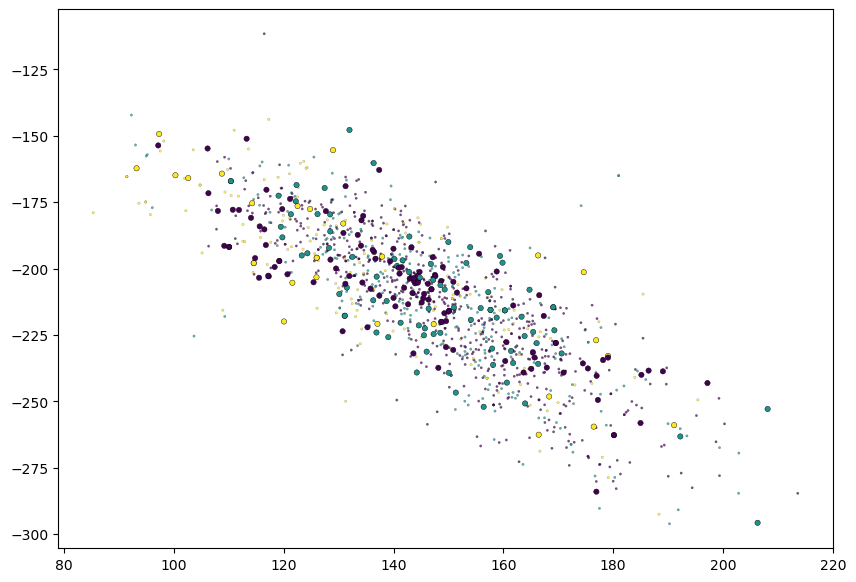

In [44]:
X_train_grae = BaseDataset(domain_2_object.data, np.array(domain_2_object.labels), split="none", split_ratio=0.8, random_state=42)
B_X_test_grae = BaseDataset(domain_2_object.test_data, np.array(domain_2_object.test_labels), split="none", split_ratio=0.8, random_state=42)
graeB.plot(X_train_grae, B_X_test_grae, cmap="viridis")

In [45]:
# See how accurate it is on the domain B (tau) test points
new_embedded_points = graeB.transform(B_X_test_grae)

# Predict on the test set
predictions = model.predict(new_embedded_points)

# Evaluate accuracy
accuracy = accuracy_score(domain_2_object.test_labels, predictions)


# Print all accuracy scores

domain_1_dataset_score = domain_1_object.dataset_accuracy
domain_1_distances_score = domain_1_object.distances_accuracy
domain_2_dataset_score = domain_2_object.dataset_accuracy
domain_2_distances_score = domain_2_object.distances_accuracy
manifold_oob = mash_object.get_scores(labels=y_train, n_jobs=-1)

print(f"Beginning Dataset Score: {domain_2_dataset_score}")
print(f"Practical Test Accuracy: {accuracy:.4f}")


Beginning Dataset Score: 0.5829787234042553
Practical Test Accuracy: 0.5197
